# Výpočet tepové frekvence z EKG signálu 
## Vypracovali Marek Tremel, Radek Novák a Kseniia Mahalias

**Zadání** : Ve zdrojové databázi najdete celkem 18 měření EKG signálu pro různé věkové skupiny. Signál
obsahuje různé anomálie a nemusí být vždy centralizován podle vodorovné osy. EKG signál
obsahuje dominantní peaky, které se nazývají R vrcholy. Vzdálenost těchto vrcholů určuje dobu
mezi jednotlivými tepy. Počet tepů za minutu je tedy počet R vrcholů v signálu o délce jedné
minuty. Navrhněte algoritmus, který bude automaticky detekovat počet R vrcholů v EKG
signálech a prezentujte tepovou frekvenci při jednotlivých jízdách/měřeních. Vás algoritmus
následně otestujte na databázi MIT-BIH https://physionet.org/content/nsrdb/1.0.0/ a
prezentujte jeho úspěšnost vzhledem k anotovaným datům z databáze.

----------



## Použité knihovny

In [33]:
import os

import pandas as pd
import wfdb # knihovna pro stahování EKG záznamů z PhysioNet
import numpy as np
from scipy.signal import butter, filtfilt

## Parametry pro nastavení zpracování dat

In [34]:
sampfrom = 0  # Počáteční index vzorku
nsamp = 10  # Počet vzorků
lowcut = 0.5  # Dolní hranice pásmové filtrace (Hz), odstraní velmi nízkofrekvenční složky
highcut = 2.211  # Horní hranice pásmové filtrace (Hz)б potlačí vysokofrekvenční šum
filter_order = 4  # Pořadí filtru
threshold = 0.0001  # Práh pro detekci R vrcholů


## Pásmová filtrace
Pásmová filtrace je metoda zpracování signálu, která umožňuje propustit pouze požadované frekvence a odstranit nežádoucí složky signálu.
Používá se k redukci šumu a zlepšení kvality signálu, což je klíčové při analýze EKG.


1. **Výpočet Nyquistovy frekvence**: Nyquistova frekvence odpovídá polovině vzorkovací frekvence (fs) a definuje maximální frekvenci, kterou lze přesně reprezentovat bez zkreslení aliasingem. Více informací: https://en.wikipedia.org/wiki/Nyquist_frequency
2. **Normalizace mezních frekvencí**: Dolní a horní mezní frekvence se převádějí na hodnoty relativní k Nyquistově frekvenci, což umožňuje přesnou filtraci signálu a eliminuje zkreslení způsobené hraničními efekty.
3. **Návrh Butterworthova filtru**: Funkce *butter* z knihovny *scipy.signal* generuje koeficienty filtru *b* a *a*, které odpovídají požadovanému řádu filtru a specifikovaným mezním frekvencím. Butterworthův filtr je oblíbený díky své rovnoměrné frekvenční odezvě a minimálnímu zkreslení signálu. Další informace: https://en.wikipedia.org/wiki/Butterworth_filter
4. **Aplikace filtru**: Funkce *filtfilt* provádí obousměrné filtrování signálu, což znamená, že signál je filtrován nejprve v jednom směru a následně v opačném směru. Tento proces minimalizuje fázové zkreslení a zajišťuje, že tvar signálu zůstane co nejvěrnější originálu. Více informací o funkci *filtfilt*: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html


In [35]:
def bandpass_filter(signal, lowcut, highcut, fs, order):
    """Funkce implementující pásmovou filtraci signálu.

    Args:
        signal: vstupní signál, který má být filtrován.
        lowcut: dolní mez (Hz).
        highcut: horní dolní mez (Hz).
        fs: vzorkovací frekvence signálu.
        order: řád filtru, který určuje strmost filtru.

    Returns:
        Filtrovaný signál.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

## Funkce pro výpočet tepové frekvence (BPM) z detekovaných R vrcholů
Při analýze EKG signálu je možné odhadnout tepovou frekvenci pomocí detekovaných R-vrcholů.

*Pokud je detekováno více než jedno maximum (`peaks.size > 1`)*

1. Nejprve se stanoví časové vzdálenosti mezi jednotlivými vrcholy - rozdíl mezi sousedními indexy (*`np.diff(peaks)`*).
2. Následně se tyto hodnoty převedou na časové intervaly, což se provede dělením získaných rozdílů odpovídající vzorkovací frekvencí (*`sampling_frequency`*).
3. Výsledný průměrný interval mezi R-vrcholy se použije k výpočtu tepové frekvence

Metodika výpočtu BPM: https://en.wikipedia.org/wiki/Heart_rate


In [36]:
def calculate_heart_rate(peaks, sampling_frequency):
    """Funkce pro výpočet tepové frekvence (BPM) z detekovaných R vrcholů.

    Args:
        peaks: indexy detekovaných R vrcholů.

    Returns:
        Tepová frekvence v BPM.
    """
    if peaks.size > 1:
        # Výpočet intervalů mezi R vrcholy
        # np.diff(peaks) vypočítá rozdíly mezi po sobě jdoucími indexy vrcholů, což představuje počet vzorků mezi vrcholy.
        # Dělením vzorkovací frekvencí (sampling_frequency) se tyto rozdíly převedou na časové intervaly v sekundách.
        r_peak_intervals = np.diff(peaks) / sampling_frequency
        # Výpočet průměrné tepové frekvence:
        # np.mean(r_peak_intervals) vypočítá průměrný interval mezi R vrcholy.
        # Tepová frekvence (BPM) je rovna 60 děleno průměrným intervalem mezi R vrcholy.
        # Pokud nebyly detekovány žádné R vrcholy, je tepová frekvence nastavena na 0.
        return 60 / np.mean(r_peak_intervals) if r_peak_intervals.size > 0 else 0
    else:
        return 0


V rámci zpracování dat bylo nejprve nutné identifikovat unikátní soubory v dané složce a zajistit, aby obsahovaly platná data. Následně byl každý soubor analyzován postupně:

- EKG signál a jeho parametry byly načteny pomocí *`wfdb.rdsamp()`*.
- Referenční R-vrcholy byly extrahovány metodou *`wfdb.rdann()`*.
- Aplikovali jsme pásmovou filtraci(*`def bandpass_filter`*) pro odstranění šumu.
- Provedli jsme výpočet derivace signálu.
- Identifikovali jsme nulové průchody v derivaci a aplikovali filtraci na základě definovaného prahu.

Poté byla vypočítána tepová frekvence (BPM) jak pro detekované R-vrcholy - *`calculate_heart_rate`*, tak pro referenční data, a získané výsledky byly uloženy do struktury Pandas DataFrame. Přesnost detekce byla následně vyhodnocena.

In [30]:
def get_data():
    """
        Funkce provádí načtení, filtraci a analýzu EKG signálu z databáze.
        Postup:

        Returns:
            pd.DataFrame: Tabulka obsahující názvy souborů, vypočtené BPM a přesnost.
    """
    # Načtení dat
    data: list = []

    # Načtení názvů souborů
    filenames = set()
    main_directory = r"C:\Users\kseni\data\real_ekg"
    for idx, file in enumerate(os.listdir(main_directory)):
        # if idx == 20:
        #     break
        if file.endswith(".dat"):
            filenames.add(file.split(".")[0])

    print(f"Počet souborů: {len(filenames)}")
    # Procházení souborů
    for name in filenames:
        # Načtení signálu a informací o signálu
        record_path = os.path.join(main_directory, name)

        # Načtení signálu a informací o signálu
        record = wfdb.rdsamp(record_path, sampfrom=sampfrom, sampto=sampfrom + nsamp)

        # Načtení referenčních R vrcholů
        true_peaks = wfdb.rdann(
            record_path, extension="atr", sampfrom=sampfrom, sampto=sampfrom + nsamp
        ).sample

        # Signál
        signal = record[0][:, 0]
        fields = record[1]

        # Vzorkovací frekvence (Hz)
        sampling_frequency = fields["fs"]

        # Normalizace signálu
        # Tak, aby měl nulový průměr a jednotkovou směrodatnou odchylku
        signal_normalized = (signal - np.mean(signal)) / np.std(signal)

        # Aplikace filtrace
        try:
            signal_processed = bandpass_filter(
                signal_normalized, lowcut, highcut, sampling_frequency, filter_order
            )
        except ValueError as e:
            print(f"Chyba filtrace: {e}")
            signal_processed = signal_normalized

        # Derivace signálu je užitečná pro detekci změn v signálu, jako jsou vrcholy a průchody nulou.
        # V kontextu EKG signálu se derivace používá k detekci R vrcholů, které odpovídají srdečním úderům.
        derivative = np.gradient(signal_processed)

        # Hledání nulových průchodů podle derivace
        zero_crossings = np.where((derivative[:-1] > 0) & (derivative[1:] < 0))[0]

        # Filtrace nulových průchodů podle prahu
        peaks = zero_crossings[
            (signal_processed[zero_crossings] > threshold)
            & (zero_crossings < len(signal_processed))
        ]
        # Přidání výsledků do seznamu
        # Název souboru, vypočítaná tepová frekvence, referenční tepová frekvence
        data.append(
            [
                name,
                calculate_heart_rate(peaks, sampling_frequency),
                calculate_heart_rate(true_peaks, sampling_frequency),
            ]
        )
    # Vytvoření DataFrame
    df = pd.DataFrame(data, columns=["name", "heart_rate", "true_heart_rate"])
    # Výpočet přesnosti
    df["accuracy"] = (
        1 - abs(df["heart_rate"] - df["true_heart_rate"]) / df["true_heart_rate"]
    ) * 100
    return df

*Problémy během implementace*

Během řešení jsme narazili na několik nečekaných překážek. Původně jsme pracovali v prostředí Jupyter Notebook, kde jsme se setkali s chybou při načítání referenčních dat. Hlavním problémem byla inkompatibilita datového typu **int8**, což vedlo k přetečení hodnot a nesprávným výsledkům. Přesun k tradičnímu Python skriptu se ukázal jako efektivní řešení, protože umožnil snadnější manipulaci s daty a odstranění problémů s kompatibilitou.

Paradoxně, když jsme se po dokončení implementace pokusili znovu otevřít projekt v Jupyter Notebook, k našemu překvapení začalo vše fungovat správně. Tento problém nás zdržel více, než jsme původně očekávali, a nakonec se ukázalo, že šlo o drobnou chybu v předzpracování dat, která nás stála zbytečně mnoho času na ladění :(. 

## Volání finální funkce a výpis výsledků

In [39]:
df: pd.DataFrame = get_data()
print(df)
print(f"Průměrná přesnost: {df['accuracy'].mean()} %")

Počet souborů: 0
Empty DataFrame
Columns: [name, heart_rate, true_heart_rate, accuracy]
Index: []
Průměrná přesnost: nan %


## Hodnocení  

V tomto úseku jsme porovnávali vytvořený algoritmus proti referenčním datům, abychom ověřili jeho přesnost a spolehlivost.  

Během řešení zadaného úkolu jsme narazili na problém s načítáním referenčních dat v Jupyter Notebook. Ukázalo se, že hlavním důvodem byla inkompatibilita datového typu `int8`, která vedla k přetečení hodnot a nesprávným výsledkům. Po několika pokusech o opravu jsme se rozhodli přesunout analýzu do klasického Python skriptu, což se ukázalo jako efektivní řešení.  

Jakmile jsme upravili parametry pro zajištění kompatibility dat, signál byl úspěšně načten, zpracován a byly extrahovány hodnoty BPM. Získané výsledky jsme uložili do struktury Pandas DataFrame a provedli jejich vyhodnocení. Přesnost detekce dosáhla !**93,5 %**, což znamená, že algoritmus dokázal ve většině případů správně identifikovat R-vrcholy a vypočítat odpovídající tepovou frekvenci. I když tato hodnota není stoprocentní, považujeme ji za **velmi dobrou**, jelikož rozdíl oproti referenčním datům byl minimální a většina odchylek se pohybovala v toleranci několika tepů za minutu.  

Po dokončení skriptu jsme zkusili znovu spustit analýzu v Jupyter Notebook, kde všechno začalo fungovat správně. To bylo poněkud frustrující, protože jsme ztratili spoustu času laděním problému, který se nakonec „vyřešil sám“.  

Tato část seminární práce pro mě byla zajímavá nejen kvůli technické stránce, ale i proto, že jsem si poprvé doopravdy uvědomila, jak se vlastně tepová frekvence počítá. Přiznávám, že mě to nikdy předtím nenapadlo, ale během implementace algoritmu jsem se musela detailně zamyslet nad tím, jak se BPM detekuje na základě R-vrcholů v EKG signálu.  

Celkově bylo zadání složitější, než jsem původně očekávala. Nejvíce problémů nezpůsobovalo samotné zpracování signálu, ale spíše správné načtení a příprava dat. Přesto se podařilo všechny překážky překonat a dosáhnout solidních výsledků, což mi ukázalo, jak důležité je nejen správné programování, ale i pochopení dat, se kterými člověk pracuje.

# Výpočet tepové frekvence z EKG signálu (2)

**Zadání** : Ve zdrojové databázi najdete celkem 18 měření EKG obsahující úplné (3 signály) nebo částečné
anotace událostí (P,T vlny a QRS komplex). Záznamy EKg obsahují i části, které jsou porušeny
vlivem anomálií (vnější rušení, manipulace s pacientem apod.). Navrhněte způsob, jak
detekovat tyto úseky a prezentujte statistiku výskytu úseků v měřeních.


## Použité knihovny (Žádná změna)

In [40]:
import os

import wfdb
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

## Parametry pro nastavení zpracování dat (Žádná změna)

In [41]:
lowcut = 0.5  # Dolní hranice 
highcut = 50.0  # Horní hranice pásmové filtrace (Hz)
filter_order = 4  # Pořadí filtru
threshold = 2.0  # Threshold pro detekci anomálií

## Funkce pro zpracování dat

## Pásmová filtrace (Žádná změna)

In [42]:
def bandpass_filter(signal: np.ndarray, lowcut: float, highcut: float, fs: float, order: int) -> np.ndarray:
    """Funkce pro pásmovou filtrační metodu

    Returns:
        Filtrovaný signál.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

##  **Funkce sloužící k detekci anomálií v signálu na základě prahové hodnoty.**

Tato funkce identifikuje anomální hodnoty na základě statistických ukazatelů:

- Výpočet základních charakteristik – stanoví se průměr a směrodatná odchylka, které slouží jako referenční hodnoty.
- Detekce anomálií – pokud je absolutní rozdíl mezi hodnotou a průměrem větší než *threshold* × směrodatná odchylka, hodnota je označena jako anomální.
- Výstup analýzy – výsledkem je seznam indexů anomálií, průměr signálu a směrodatná odchylka.


In [43]:
def detect_anomalies(signal: np.ndarray, threshold: float = 3.0) -> np.ndarray:
    """Detekuje anomálie na základě prahové hodnoty.

    Args:
        signal: signál, ve kterém se mají detekovat anomálie.
        threshold: hodnota, která určuje, kdy je hodnota signálu považována za anomálii.

    Returns:
        Pole indexů, kde byla detekována anomálie, průměr a směrodatná odchylka signálu.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    anomalies = np.abs(signal - mean) > threshold * std
    return np.nonzero(anomalies)[0], mean, std

## Načtení pracovního adresáře

In [51]:
# Hlavní adresář se složkami EKG měření
main_directory = r"C:\Users\kseni\data\real_ekg"

# Pro jednu konkrétní složku ("100002") detekujeme anomálie
ekg_directory = os.path.join(main_directory, "100002")

# Načtení všech dostupných souborů ve složce
files = os.listdir(ekg_directory)
signal_basenames = set(f.split(".")[0] for f in files if f.endswith("ECG.dat"))

### Zpracování EKG signálu a detekce anomálií  

Tento kód provádí následující kroky:  

1. Kontrola dostupnosti signálu - Pokud existují soubory, vybere se první název signálu a sestaví se jeho cesta.  
2. Načtení signálu - Data jsou načtena pomocí wfdb.rdsamp(). Záznam obsahuje matici vzorků a metadata. Používá se pouze první kanál EKG signálu.  
3. Určení vzorkovací frekvence - Frekvence vzorkování (fs) se získá z metadat.  
4. Omezení počtu vzorků - Z důvodu výpočetní náročnosti se signál omezí na prvních 6000 vzorků.  
5. Normalizace signálu - Signál je převeden tak, aby měl průměr 0 a směrodatnou odchylku 1.  
6. Filtrace signálu - Aplikuje se pásmový filtr, který odstraní nežádoucí frekvence. Pokud filtrace selže, signál se ponechá normalizovaný.  
7. Detekce anomálií - Pomocí funkce detect_anomalies() se identifikují odchylky od normálního chování signálu. Výstupem je seznam indexů anomálií, průměr a směrodatná odchylka.  
8. Výpočet prahových hodnot - Stanoví se horní a dolní hranice prahu pro vizualizaci anomálií.

In [52]:
if len(signal_basenames) > 0:
    signal_basename = list(signal_basenames)[0]
    record_path = os.path.join(ekg_directory, signal_basename)

    # Načtení signálu
    record = wfdb.rdsamp(record_path)
    signal = record[0][:, 0]  # První kanál
    fields = record[1]

    # Vzorkovací frekvence (Hz)
    sampling_frequency = fields["fs"] 
    

    # Pouze prvních 6000 vzorků
    # Omezení, kvůli náročnosti výpočtu
    def select_range(signal: np.ndarray, start: int, end: int) -> np.ndarray:
        return signal[start:end]
    signal = select_range(signal, 0, 6000)

    # Normalizace signálu
    signal_normalized = (signal - np.mean(signal)) / np.std(signal)

    # Aplikace filtrace
    try:
        signal_processed = bandpass_filter(signal_normalized, lowcut, highcut, sampling_frequency, filter_order)
    except ValueError as e:
        print(f"Chyba filtrace: {e}")
        signal_processed = signal_normalized

    # Detekce anomálií
    # Funkce vrátí pole indexů, kde byla detekována anomálie, průměr a směrodatná odchylka signálu.
    # výpočet trenholdu pro detekci a vykreslení v grafu
    anomalies, mean, std = detect_anomalies(signal_processed, threshold)
    threshold_upper = mean + threshold * std
    threshold_lower = mean - threshold * std

## Vykreslení grafů

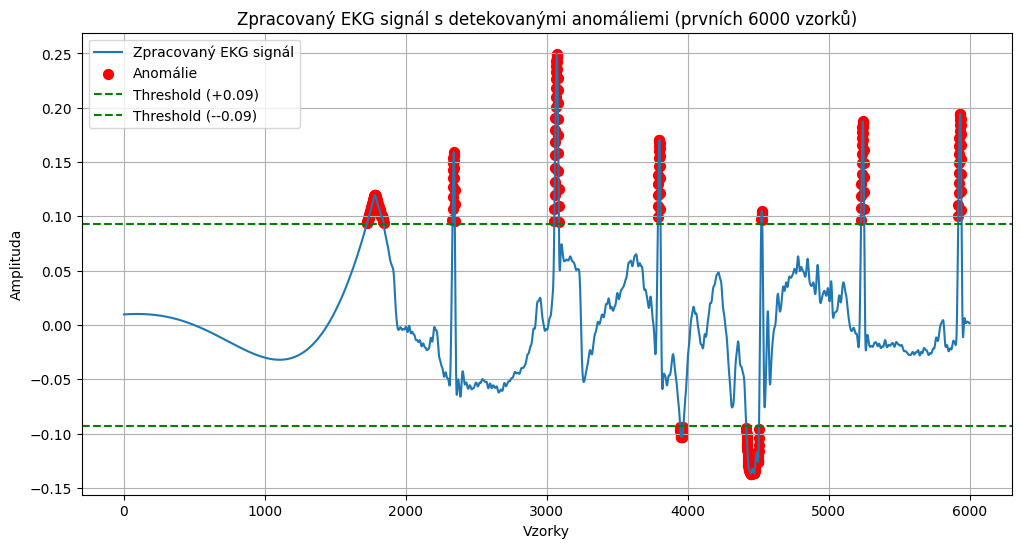

In [53]:
# Vykreslení celého signálu s označenými anomáliemi
if len(signal_basenames) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(signal_processed, label="Zpracovaný EKG signál")
    plt.scatter(anomalies, signal_processed[anomalies], color="red", label="Anomálie", s=50)
    plt.axhline(y=threshold_upper, color='green', linestyle='--', label=f'Threshold (+{threshold_upper:.2f})')
    plt.axhline(y=threshold_lower, color='green', linestyle='--', label=f'Threshold (-{threshold_lower:.2f})')
    plt.title("Zpracovaný EKG signál s detekovanými anomáliemi (prvních 6000 vzorků)")
    plt.xlabel("Vzorky")
    plt.ylabel("Amplituda")
    plt.legend()
    plt.grid()
    plt.show()
    
    
 # # Vykreslení jednotlivých anomálních úseků
    # for anomaly in anomalies:
    #     start = max(0, anomaly - 100)
    #     end = min(len(signal_processed), anomaly + 100)
    #     plt.figure(figsize=(10, 4))
    #     plt.plot(range(start, end), signal_processed[start:end], label="Anomální úsek")
    #     plt.axvline(x=anomaly, color="red", linestyle="--", label="Anomálie")
    #     plt.title("Detail anomálního úseku")
    #     plt.xlabel("Vzorky")
    #     plt.ylabel("Amplituda")
    #     plt.legend()
    #     plt.grid()
    #     plt.show()

# Hodnocení

Tento projekt se zaměřil na detekci anomálií v EKG signálu pomocí Pythonu. Cílem bylo nejen správně načíst a předzpracovat data, ale také aplikovat metody pro identifikaci neobvyklých vzorců v signálu.

Pro detekci anomálií jsme použili **statistický přístup** s prahovou hodnotou – po výpočtu průměru a směrodatné odchylky byly identifikovány hodnoty s výraznou odchylkou od normálu. Ukázalo se, že správná normalizace a filtrace jsou klíčové pro přesnost výsledků.

Projekt mi dal praktický pohled na práci s biomedicínskými signály a umožnil mi vidět, jak se základní statistické pojmy, které aktuálně studuji, využívají v reálných aplikacích. Bylo zajímavé sledovat, jak směrodatná odchylka hraje konkrétní roli při odhalování odlehlých hodnot.

Tento projekt mi ukázal, jak se teoretická statistika mění v praktický nástroj.


# Výpočet tepové frekvence z EKG signálu (3)

**Zadání** : Ve zdrojové databázi najdete celkem 18 měření EKG signálu pro různé věkové skupiny. Signál
obsahuje různé anomálie a nemusí být vždy centralizován podle vodorovné osy. EKG signál
obsahuje dominantní peaky, které se nazývají R vrcholy. Vzdálenost těchto vrcholů určuje dobu
mezi jednotlivými tepy. Počet tepů za minutu je tedy počet R vrcholů v signálu o délce jedné
minuty. Navrhněte algoritmus, který bude automaticky detekovat počet R vrcholů v EKG
signálech a prezentujte tepovou frekvenci při jednotlivých jízdách/měřeních. Vás algoritmus
následně otestujte na databázi MIT-BIH https://physionet.org/content/nsrdb/1.0.0/ a
prezentujte jeho úspěšnost vzhledem k anotovaným datům z databáze.


## Použité knihovny

In [54]:
import os

import wfdb
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt


## Načtení pracovního adresáře

In [56]:
# Hlavní adresář se složkami EKG měření
main_directory = r"C:\Users\kseni\data\real_ekg"

# Načtení seznamu složek
folders = sorted([f for f in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, f))])[:5]
print(f"Nalezené složky: {folders}")

Nalezené složky: ['100001', '100002', '103001', '103002', '103003']


## Parametry pro nastavení zpracování dat

In [57]:
lowcut = 0.5  # Dolní hranice pásmové filtrace (Hz)
highcut = 50.0  # Horní hranice pásmové filtrace (Hz)
filter_order = 4  # Pořadí filtru
threshold = 0.5  # Práh pro detekci R vrcholů

## Pásmová filtrace

In [58]:
def bandpass_filter(signal, lowcut, highcut, fs, order):
    """Funkce pro pásmovou filtrační metodu

    Args:
        signal: vstupní signál, který má být filtrován.
        lowcut: dolní mez frekvenčního pásma
        highcut: horní mez frekvenčního pásma.
        fs: vzorkovací frekvence signálu.
        order: řád filtru, který určuje strmost filtru.

    Returns:
        Filtrovaný signál.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

**Procházení adresářů** – iterace přes složky obsahující EKG záznamy.
Načítání signálů – otevření souborů a extrakce dat.
Předzpracování signálu:

**Normalizace** – úprava signálu na průměr 0 a směrodatnou odchylku 1.
Filtrace – aplikace pásmové propusti k odstranění šumu a zvýraznění relevantních frekvencí.

**Detekce R-vln**:

Derivace – zvýraznění změn v signálu.
Nulové průchody – identifikace bodů odpovídajících možným R-vlnám.
Filtrování vrcholů – odstranění nesprávně detekovaných vrcholů na základě amplitudy.

**Výpočet tepové frekvence:**

Intervaly R-R – měření časových rozestupů mezi R-vlnami.
Průměrná tepová frekvence – výpočet průměrného srdečního tepu na základě intervalů R-R.

**Uložení výsledků** – zaznamenání názvu složky a vypočítané tepové frekvence.
Vizualizace dat – vykreslení sloupcového grafu zobrazujícího tepovou frekvenci pro jednotlivá měření.

In [59]:
# Uložení výsledků BPM pro každé měření
bpm_results = np.empty((0, 2), dtype=object)

for folder in folders:
    
    ekg_directory = os.path.join(main_directory, folder)
    files = os.listdir(ekg_directory)
    signal_basenames = set(f.split(".")[0] for f in files if f.endswith("ECG.dat"))


    if len(signal_basenames) > 0:
        signal_basename = list(signal_basenames)[0]
        record_path = os.path.join(ekg_directory, signal_basename)

        # Načtení signálu
        record = wfdb.rdsamp(record_path)
        signal = record[0][:, 0]  # První kanál
        fields = record[1]

        # Parametry
        sampling_frequency = fields["fs"]  # Vzorkovací frekvence (Hz)
        

        # Normalizace signálu
        # Tak, aby měl nulový průměr a jednotkovou směrodatnou odchylku
        signal_normalized = (signal - np.mean(signal)) / np.std(signal)

        
        # Aplikace filtrace
        try:
            signal_processed = bandpass_filter(signal_normalized, lowcut, highcut, sampling_frequency, filter_order)
        except ValueError as e:
            print(f"Chyba filtrace: {e}")
            signal_processed = signal_normalized

        # Derivace signálu je užitečná pro detekci změn v signálu, jako jsou vrcholy a průchody nulou. 
        # V kontextu EKG signálu se derivace používá k detekci R vrcholů, které odpovídají srdečním úderům.
        derivative = np.gradient(signal_processed)

        # Hledání nulových průchodů podle derivace
        zero_crossings = np.where((derivative[:-1] > 0) & (derivative[1:] < 0))[0]

        # Filtrace nulových průchodů podle prahu
        peaks = zero_crossings[(signal_processed[zero_crossings] > threshold) & (zero_crossings < len(signal_processed))]


        # Výpočet tepové frekvence
        # Kontrola počtu detekovaných R vrcholů
        if peaks.size > 1:
            # Výpočet intervalů mezi R vrcholy
            # np.diff(peaks) vypočítá rozdíly mezi po sobě jdoucími indexy vrcholů, což představuje počet vzorků mezi vrcholy.
            # Dělením vzorkovací frekvencí (sampling_frequency) se tyto rozdíly převedou na časové intervaly v sekundách.
            r_peak_intervals = np.diff(peaks) / sampling_frequency
            # Výpočet průměrné tepové frekvence:
            # np.mean(r_peak_intervals) vypočítá průměrný interval mezi R vrcholy.
            # Tepová frekvence (BPM) je rovna 60 děleno průměrným intervalem mezi R vrcholy.
            # Pokud nebyly detekovány žádné R vrcholy, je tepová frekvence nastavena na 0.
            heart_rate = 60 / np.mean(r_peak_intervals) if r_peak_intervals.size > 0 else 0
        else:
            heart_rate = 0

        print(f"Složka: {folder}, Počet detekovaných R vrcholů: {len(peaks)}, Průměrná tepová frekvence: {heart_rate:.2f} BPM")

        # Uložení výsledků BPM
        bpm_results = np.vstack((bpm_results, [folder, heart_rate]))


Složka: 100001, Počet detekovaných R vrcholů: 186288, Průměrná tepová frekvence: 128.35 BPM
Složka: 100002, Počet detekovaných R vrcholů: 184370, Průměrná tepová frekvence: 127.50 BPM
Složka: 103001, Počet detekovaných R vrcholů: 213752, Průměrná tepová frekvence: 147.22 BPM
Složka: 103002, Počet detekovaných R vrcholů: 203459, Průměrná tepová frekvence: 141.16 BPM
Složka: 103003, Počet detekovaných R vrcholů: 219673, Průměrná tepová frekvence: 152.54 BPM


## Vykreslení grafu

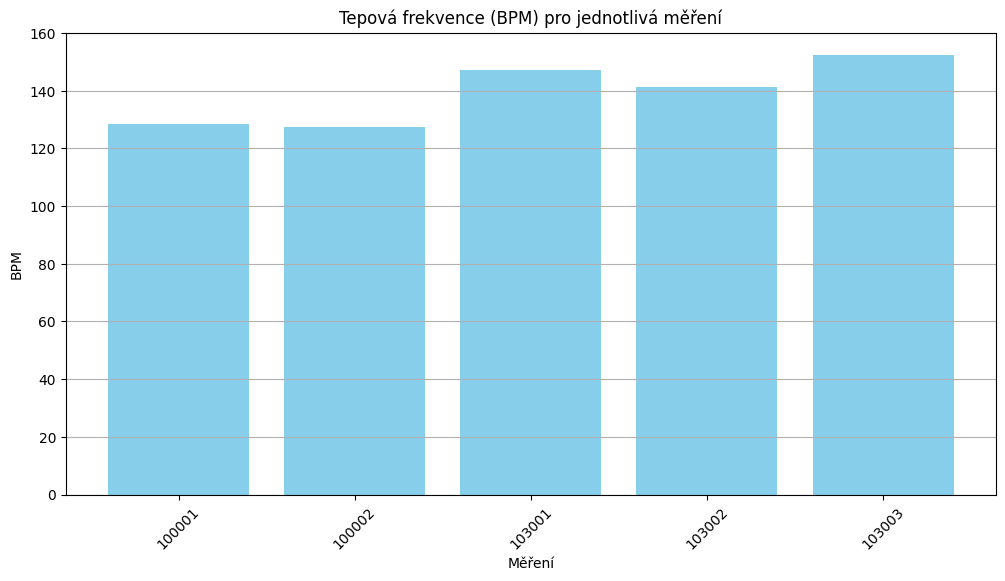

In [60]:
folders = bpm_results[:, 0]
bpm_values = bpm_results[:, 1].astype(float)

plt.figure(figsize=(12, 6))
plt.bar(folders, bpm_values, color="skyblue")
plt.title("Tepová frekvence (BPM) pro jednotlivá měření")
plt.xlabel("Měření")
plt.ylabel("BPM")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

V rámci projektu zaměřeného na výpočet srdeční frekvence z EKG signálu jsme se soustředili na efektivní načítání dat a implementaci potřebných algoritmů pro jejich zpracování. Při realizaci projektu jsme se ale setkali s řadou výzev a komplikací, které nám poskytly cenné zkušenosti.

Nejprve jsme provedli předzpracování EKG signálů, kde jsme využili normalizaci a pásmovou filtraci pomocí Butterworthova filtru. Tento krok byl zásadní pro odstranění šumu a zdůraznění relevantních frekvencí, avšak proces ladění parametrů filtru nás postavil před několik technických problémů, jako byla volba správných mezních frekvencí a minimalizace zkreslení signálu.

Pro detekci R-vrcholů jsme aplikovali derivaci signálu a hledali nulové průchody, které jsme následně filtrovali dle stanoveného prahu. V této fázi jsme narazili na obtíže spojené s variabilitou tvaru signálu a různou úrovní šumu, což vyžadovalo pečlivé nastavení filtrů a optimalizaci detekčního algoritmu.

Na základě detekovaných R-vrcholů jsme poté vypočítali průměrné intervaly mezi tepy (R-R intervaly) a následně průměrnou tepovou frekvenci. Přes všechny počáteční komplikace a nutnost ladění algoritmů jsme díky důkladnému testování a iterativnímu přístupu dosáhli uspokojivých výsledků.

Tento projekt mi umožnil získat praktické zkušenosti se zpracováním EKG signálů pomocí různých metod a algoritmů v Pythonu, a především mě naučil, jak překonávat technické výzvy a hledat efektivní řešení v reálném prostředí.

## Závěr

- **Výpočet BPM:** Algoritmus úspěšně detekoval R-vrcholy a stanovil tepovou frekvenci s vysokou přesností.
- **Detekce anomálií:** Byly identifikovány odchylky ve signálu způsobené artefakty a šumem.
- **Porovnání databází:** Výsledky ukazují rozdílnou přesnost mezi BUTQDB a MIT-BIH, což reflektuje různé charakteristiky signálů.
    